<a href="https://colab.research.google.com/github/Sky0307/2022DLProject/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import h5py
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
directory = "drive/MyDrive/datasets/"

# Default Params

In [4]:
class Parameters:
    def __init__(self):
        self.batch_size = None
        self.label_size = 10
        self.epoch_num = None
        self.sample_rate = 16000
        self.use_cuda = True
        self.cuda = torch.cuda.is_available() and self.use_cuda
        self.log_step = None
        self.dataset_len = None
        self.dictionary = {0: 'pop',
                           1: 'metal',
                           2: 'disco',
                           3: 'blues',
                           4: 'reggae',
                           5: 'classical',
                           6: 'rock',
                           7: 'hiphop',
                           8: 'country',
                           9: 'jazz'}
        self.r_dictionary = {'pop': 0,
                             'metal': 1,
                             'disco': 2,
                             'blues': 3,
                             'reggae': 4,
                             'classical': 5,
                             'rock': 6,
                             'hiphop': 7,
                             'country': 8,
                             'jazz': 9}

        # pure GTZAN dataset
        self.GTZAN_TRAIN_DATA = directory + 'training dataset/train.h5'
        self.GTZAN_VAL_DATA = directory + 'training dataset/valid.h5'
        self.GTZAN_TEST_DATA = directory + 'training dataset/test.h5'

        # custom dataset 1
        self.TRAIN_DATA_1 = directory + 'training dataset/custom_train.h5'
        self.VAL_DATA_1 = directory + 'training dataset/custom_valid.h5'
        self.TEST_DATA_1 = directory + 'training dataset/custom_test.h5'

        # custom dataset 2
        self.TRAIN_DATA_2 = directory + 'training dataset/custom_train_2.h5'
        self.VAL_DATA_2 = directory + 'training dataset/custom_valid_2.h5'
        self.TEST_DATA_2 = directory + 'training dataset/custom_test_2.h5'

        self.MODEL_SAVE_FOLDER = directory + 'model/'
        self.LOG_SAVE_FOLDER = directory + 'log/'

        if self.cuda:
            self.kwargs = {'num_workers': 1, 'pin_memory': True}
        else:
            self.kwargs = {}

        self.learning_rate = 1e-5

    def __str__(self):
        out_string = "The Batch Size is {0}\n" \
                     "The Label Size is {1}\n" \
                     "The Epoch Num is {2}\n" \
                     "The Cuda is set to {3}\n" \
                     "The log step is {4}".format(self.batch_size,
                                                  self.label_size,
                                                  self.epoch_num,
                                                  self.cuda,
                                                  self.log_step)
        return out_string

In [5]:
Para = Parameters()
Para.learning_rate = 1e-5
Para.batch_size = 20
Para.epoch_num = 40
print(Para)

The Batch Size is 20
The Label Size is 10
The Epoch Num is 40
The Cuda is set to True
The log step is None


In [6]:
class TorchData(Dataset):
  """
  To build the data loader
  """

  def __init__(self, dataset_path):
      """
      Take the h5py dataset
      """
      super(TorchData, self).__init__()
      self.dataset = h5py.File(dataset_path, 'r')
      self.mel = self.dataset['mel']
      self.tag = self.dataset['tag']

      self.len = self.mel.shape[0]

  def __len__(self):
      return self.len

  def __getitem__(self, index):
      mel = self.mel[index].astype(np.float32)
      mel = np.reshape(mel, (1, mel.shape[0], mel.shape[1]))
      mel = torch.from_numpy(mel)
      tag = torch.from_numpy(self.tag[index].astype(np.float32))
      sample = {"mel": mel, "tag": tag}

      return sample


# define the data loaders
def torch_dataset_loader(dataset, batch_size, shuffle, kwargs):
    """
    take the h5py dataset
    """
    loader = DataLoader(TorchData(dataset),
                        batch_size=batch_size,
                        shuffle=shuffle,
                        **kwargs)
    return loader

In [7]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(conv1.weight)
        self.conv_block1 = nn.Sequential(conv1,
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(conv2.weight)
        self.conv_block2 = nn.Sequential(conv2,
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))

        conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(conv3.weight)
        self.conv_block3 = nn.Sequential(conv3,
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=4))

        conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(conv4.weight)
        self.conv_block4 = nn.Sequential(conv4,
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=4))

        self.fc_block1 = nn.Sequential(nn.Linear(in_features=2048, out_features=1024),
                                      nn.ReLU(),
                                      nn.Dropout(0.6))

        self.fc_block2 = nn.Sequential(nn.Linear(in_features=1024, out_features=256),
                                      nn.ReLU(),
                                      nn.Dropout(0.5))

        self.output = nn.Sequential(nn.Linear(in_features=256, out_features=10),
                                    nn.Softmax(dim=1))

    def forward(self, input):
        output = self.conv_block1(input)
        output = self.conv_block2(output)
        output = self.conv_block3(output)
        output = self.conv_block4(output)

        output = output.view(output.size()[0], -1)
        output = self.fc_block1(output)
        output = self.fc_block2(output)
        final_out = self.output(output)
        return final_out

# Util function

In [8]:
def accuracy_function(output, target):
    f_output = output.cpu() if Para.cuda else output.clone()
    f_target = target.cpu() if Para.cuda else target.clone()

    output_res = f_output.detach().numpy()
    target_res = f_target.detach().numpy()
    predicted_index = np.argmax(output_res, axis=1)
    
    target_index = np.argmax(target_res, axis=1)

    # counter
    correct = np.sum(predicted_index == target_index)
    accuracy = correct / (output.shape[0])
    return accuracy


def matrix_tuple(output, target):
    f_output = output.cpu() if Para.cuda else output.clone()
    f_target = target.cpu() if Para.cuda else target.clone()

    output_res = f_output.detach().numpy()
    target_res = f_target.detach().numpy()
    predicted_index = np.argmax(output_res, axis=1)
    target_index = np.argmax(target_res, axis=1)
    result_list = [[int(predicted_index[i]), int(target_index[i])] for i in range(len(predicted_index))]
    return result_list


# def bce_loss(output, target):
#     loss_mlp = nn.BCELoss()
#     loss = loss_mlp(output, target)
#     return loss

# Train

In [9]:
def train(model, epoch, train_loader, optimizer, versatile=True):
    start_time = time.time()
    model = model.train()
    train_loss = 0.
    accuracy = 0.
    batch_num = len(train_loader)
    _index = 0

    for _index, data in enumerate(train_loader):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        predicted = model(spec_input)

        # loss_value = bce_loss(predicted, target)
        loss_mlp = nn.BCELoss()
        loss_value = loss_mlp(predicted, target)
        accuracy_value = accuracy_function(predicted, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value.data.item()
        accuracy += accuracy_value

        if versatile:
            if (_index + 1) % Para.log_step == 0:
                elapsed = time.time() - start_time
                print('Epoch{:3d} | {:3d}/{:3d} batches | {:5.2f}ms/ batch | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
                      .format(epoch, _index + 1, batch_num,
                              elapsed * 1000 / (_index + 1),
                              train_loss / (_index + 1),
                              accuracy * 100 / (_index + 1)))

    train_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('-' * 99)
    print('End of training epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  train_loss, accuracy * 100))

    return train_loss, accuracy


def test(model, epoch, use_loader):
    start_time = time.time()
    model = model.eval()
    v_loss = 0.
    accuracy = 0.
    data_loader_use = use_loader
    _index = 0
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)

            # loss_value = bce_loss(predicted, target)

            loss_mlp = nn.BCELoss()
            loss_value = loss_mlp(predicted, target)
            
            accuracy_value = accuracy_function(predicted, target)

            v_loss += loss_value.data.item()
            accuracy += accuracy_value

    v_loss /= (_index + 1)
    accuracy /= (_index + 1)

    print('End of validation epoch {:3d} | time: {:5.2f}s | BCE: {:5.4f} | Accuracy: {:5.2f}% |'
          .format(epoch, (time.time() - start_time),
                  v_loss, accuracy * 100))
    print('-' * 99)

    return v_loss, accuracy


def record_matrix(model, use_loader, log_name):
    model = model.eval()
    data_loader_use = use_loader
    _index = 0
    result = list()
    for _index, data in enumerate(data_loader_use):
        spec_input, target = data['mel'], data['tag']

        if Para.cuda:
            spec_input = spec_input.cuda()
            target = target.cuda()

        with torch.no_grad():

            predicted = model(spec_input)
            m_tuple_list = matrix_tuple(predicted, target)
            result += m_tuple_list

    print('End of Matrix Record, Save file in {0}'.format(Para.LOG_SAVE_FOLDER + log_name))
    print('-' * 99)
    with open(Para.LOG_SAVE_FOLDER + log_name, 'w+') as f:
        json.dump(result, f)
    return


def main_train(model, train_loader, valid_loader, log_name, save_name, lr=Para.learning_rate, epoch_num=Para.epoch_num):
    Para.dataset_len = len(train_loader)
    Para.log_step = len(train_loader) // 4
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
    t_loss, t_accu, v_loss, v_accu = [], [], [], []

    decay_cnt = 0
    for epoch in range(1,  epoch_num + 1):
        if Para.cuda:
            model.cuda()
        train_loss, train_accuracy = train(model, epoch, train_loader, optimizer)
        validation_loss, validation_accuracy = test(model, epoch, use_loader=valid_loader)

        t_loss.append(train_loss)
        t_accu.append(train_accuracy)

        v_loss.append(validation_loss)
        v_accu.append(validation_accuracy)

        # use accuracy to find the best model
        if np.max(t_accu) == t_accu[-1]:
            print('***Found Best Training Model***')
        if np.max(v_accu) == v_accu[-1]:
            with open(Para.MODEL_SAVE_FOLDER + save_name, 'wb') as f:
                torch.save(model.cpu().state_dict(), f)
                print('***Best Validation Model Found and Saved***')

        print('-' * 99)

        # Use BCE loss value for learning rate scheduling
        decay_cnt += 1

        if np.min(t_loss) not in t_loss[-3:] and decay_cnt > 2:
            scheduler.step()
            decay_cnt = 0
            print('***Learning rate decreased***')
            print('-' * 99)

    build_dict = {
        "train_loss": t_loss,
        "train_accu": t_accu,
        "valid_loss": v_loss,
        "valid_accu": v_accu,
    }

    with open(Para.LOG_SAVE_FOLDER + log_name, 'w+') as lf:
        json.dump(build_dict, lf)

    return build_dict

In [10]:
train_dataloader = torch_dataset_loader(Para.TRAIN_DATA_2, Para.batch_size, True, Para.kwargs)
validation_dataloader = torch_dataset_loader(Para.VAL_DATA_2, Para.batch_size, False, Para.kwargs)
test_dataloader = torch_dataset_loader(Para.TEST_DATA_2, Para.batch_size, False, Para.kwargs)

# Setting Parameters

In [11]:
CNN = CnnModel()
res = main_train(model=CNN, 
                 train_loader=train_dataloader,
                 valid_loader=validation_dataloader,
                 log_name='CnnModel.json',
                 save_name='CnnModel.pt',
                 lr=Para.learning_rate,
                 epoch_num=Para.epoch_num)

Epoch  1 | 123/495 batches | 42.02ms/ batch | BCE: 0.3115 | Accuracy: 22.56% |
Epoch  1 | 246/495 batches | 39.05ms/ batch | BCE: 0.3033 | Accuracy: 26.26% |
Epoch  1 | 369/495 batches | 38.89ms/ batch | BCE: 0.2962 | Accuracy: 28.51% |
Epoch  1 | 492/495 batches | 37.32ms/ batch | BCE: 0.2892 | Accuracy: 30.73% |
---------------------------------------------------------------------------------------------------
End of training epoch   1 | time: 18.50s | BCE: 0.2890 | Accuracy: 30.75% |
End of validation epoch   1 | time:  0.85s | BCE: 0.2467 | Accuracy: 40.84% |
---------------------------------------------------------------------------------------------------
***Found Best Training Model***
***Best Validation Model Found and Saved***
---------------------------------------------------------------------------------------------------
Epoch  2 | 123/495 batches | 33.04ms/ batch | BCE: 0.2622 | Accuracy: 37.97% |
Epoch  2 | 246/495 batches | 32.91ms/ batch | BCE: 0.2577 | Accuracy: 38.96

# Test Model

In [12]:
CNN.cuda().load_state_dict(torch.load(Para.MODEL_SAVE_FOLDER + 'CnnModel.pt'))
test(model=CNN, epoch=0, use_loader=test_dataloader)

End of validation epoch   0 | time:  1.00s | BCE: 0.0701 | Accuracy: 85.78% |
---------------------------------------------------------------------------------------------------


(0.07008458397561504, 0.8577798861480075)

In [13]:
CNN.cuda().load_state_dict(torch.load(Para.MODEL_SAVE_FOLDER + 'CnnModel.pt'))
record_matrix(model=CNN, use_loader=test_dataloader, log_name='CnnMatrix.json')

End of Matrix Record, Save file in drive/MyDrive/datasets/log/CnnMatrix.json
---------------------------------------------------------------------------------------------------


# Testing on Full Song

In [15]:
class FullSongTester:
    def __init__(self, weight_path, model, size=128):
        self.model = model
        self.index = size
        self.remove = 15  # remove the first and last 15 s
        self.model.load_state_dict(torch.load(weight_path, map_location='cpu'))
        self.model = model.eval()

    def audio_loader(self, audio_path):
        y, _ = librosa.load(audio_path, mono=True, sr=Para.sample_rate)
        y = y[self.remove*Para.sample_rate: -1*self.remove*Para.sample_rate]
        y = librosa.feature.melspectrogram(y=y, sr=Para.sample_rate, n_mels=self.index).T
        y = librosa.power_to_db(y)
        if not y.shape[0] % self.index == 0:
            y = y[:-1 * (y.shape[0] % self.index)]
        chunk_num = int(y.shape[0] / self.index)
        mel_chunks = np.split(y, chunk_num)
        return mel_chunks

    def get_genre(self, audio_path):
        print("Test on {0}".format(audio_path.split('/')[-1]))
        tag_list = dict()
        idx_list = [x for x in range(10)]
        for idx in idx_list:
            tag_list[idx] = 0

        for i, data in enumerate(self.audio_loader(audio_path)):
            with torch.no_grad():
                data = torch.FloatTensor(data).view(1, 1, self.index, self.index)  # resize to fit it in model
                predict = self.model(data)
                score, tag = predict.max(1)
            tag_list[int(tag)] = tag_list.get(int(tag)) + float(score)

        _sum = sum([tag_list.get(key) for key in tag_list])

        idx_list.sort(key=lambda x: -1 * tag_list.get(x))
        tmp = dict()
        for i in idx_list:
            current_genre = Para.dictionary.get(i)
            current_score = tag_list.get(i) / _sum * 100
            tmp[i] = current_score
            if current_score == 0:
                break
            print('Genre {0}: {1}%'.format(current_genre, round(current_score, 2)))
        return idx_list[0], idx_list[1], idx_list[2], tmp


In [16]:
WEIGHT_PATH = directory + "model/"
cnn_dealer = FullSongTester(WEIGHT_PATH + "CnnModel.pt", CnnModel())

In [17]:
data_path = directory + 'sample_music/'
genre_path_dict = dict()
label_dict = Para.r_dictionary

for (dirpath, dirnames, filenames) in os.walk(data_path):
    if dirnames:
        print("dirnames: {}".format(dirnames))
        for idx, genre in enumerate(dirnames):
            genre_path_dict[genre] = list()
        continue
    else:
        genre = dirpath.split('/')[-1]
        for au_file in filenames:
            if 'mp3' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)

total_file = sum([len(genre_path_dict[genre]) for genre in genre_path_dict])
total_file, label_dict, genre_path_dict

dirnames: ['reggae', 'disco', 'rock', 'jazz', 'metal', 'blues', 'pop', 'classical', 'hiphop', 'country']


(23,
 {'blues': 3,
  'classical': 5,
  'country': 8,
  'disco': 2,
  'hiphop': 7,
  'jazz': 9,
  'metal': 1,
  'pop': 0,
  'reggae': 4,
  'rock': 6},
 {'blues': ['drive/MyDrive/datasets/sample_music/blues/Christian Willisohn - Blues In My Bottle.mp3',
   'drive/MyDrive/datasets/sample_music/blues/Buster Benton - Money Is The Name of The Game.mp3'],
  'classical': ['drive/MyDrive/datasets/sample_music/classical/F. Chopin  - Nocturne in c sharp minor for violin and piano_ YuEun Kim, Violin .mp3',
   "drive/MyDrive/datasets/sample_music/classical/Mariage d'Amour - Paul de Senneville _ Jacob's Piano.mp3",
   'drive/MyDrive/datasets/sample_music/classical/River Flows In You.mp3'],
  'country': ['drive/MyDrive/datasets/sample_music/country/Friends in low places lyrics Garth Brooks.mp3',
   'drive/MyDrive/datasets/sample_music/country/Lee Ann Womack - I Hope You Dance (Official Music Video).mp3'],
  'disco': ["drive/MyDrive/datasets/sample_music/disco/The O'Jays - Love Train.mp3",
   'drive/M

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
def test_model(dealer, save_name):
    test_result = dict()
    for key in genre_path_dict:
        test_result[key] = 0
        print('test on sample {0}'.format(key))
        for file_name in genre_path_dict.get(key):
            res1, res2, res3, score = dealer.get_genre(file_name)
            if res1 == label_dict.get(key):
                test_result[key] += score.get(res1)
            elif res2 == label_dict.get(key):
                test_result[key] += score.get(res2)
            elif res3 == label_dict.get(key):
                test_result[key] += score.get(res3)
            print("*"*99)
        test_result[key] /= 300
        print(test_result[key])
        print("+"*99)
    with open(Para.LOG_SAVE_FOLDER + save_name, 'w+') as f:
        json.dump(test_result, f)
    return
test_model(cnn_dealer, 'cnnFullSongTest.json')


test on sample reggae
Test on Shaggy - Oh Carolina 1993 (Official HQ).mp3
Genre pop: 91.41%
Genre blues: 4.9%
Genre hiphop: 3.69%
***************************************************************************************************
Test on John Holt   Police In Helicopter.mp3
Genre reggae: 95.93%
Genre hiphop: 4.07%
***************************************************************************************************
0.319756358739573
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
test on sample disco
Test on The O'Jays - Love Train.mp3
Genre disco: 88.85%
Genre rock: 7.28%
Genre country: 3.87%
***************************************************************************************************
Test on I Will Survive.mp3
Genre disco: 97.12%
Genre country: 1.67%
Genre pop: 1.21%
***************************************************************************************************
0.6198953243230944
++++++++++++++++++++++++++++++++++++++++++++++

# Visualization

## Training

In [20]:
with open(Para.LOG_SAVE_FOLDER + 'CnnModel.json', 'r') as f:
    cnn = json.load(f)

### Loss

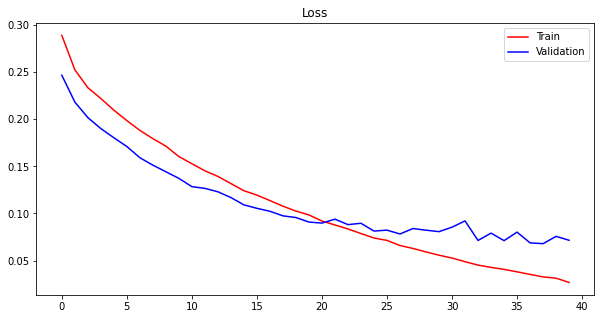

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(cnn['train_loss'], color='r', label='Train')
plt.plot(cnn['valid_loss'], color='b', label='Validation')
plt.title('Loss')
plt.legend(loc="best")
plt.savefig("drive/MyDrive/datasets/pictures/Training Loss vs Epochs")
plt.show()

### Accuracy

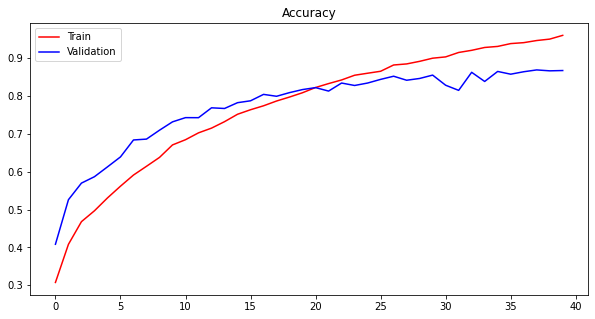

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(cnn['train_accu'], color='r', label='Train')
plt.plot(cnn['valid_accu'], color='b', label='Validation')
plt.title('Accuracy')
plt.legend(loc="best")
plt.savefig("drive/MyDrive/datasets/pictures/Training Accuracy vs Epochs")
plt.show()

### Confusion Matrix

In [40]:
cnn_m = np.zeros((10, 10))
with open(Para.LOG_SAVE_FOLDER + 'CnnMatrix.json', 'r') as f:
    cnn_l = json.load(f)

for point in cnn_l:
    i, j = point
    cnn_m[i][j] += 1

cnn_m/=sum(cnn_m)

cnn_m = pd.DataFrame(cnn_m, index = [Para.dictionary.get(i) for i in range(10)],
                  columns = [Para.dictionary.get(i) for i in range(10)],)

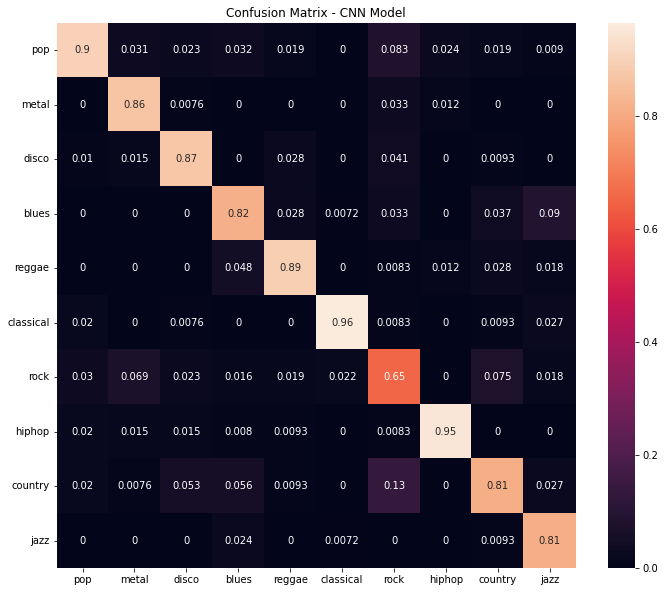

In [55]:
plt.figure(figsize=(10, 24))
plt.subplot(3, 1, 1)
plt.title('Confusion Matrix - CNN Model')
sn.heatmap(cnn_m, annot=True,)
plt.tight_layout()
plt.savefig("drive/MyDrive/datasets/pictures/matrix")

## Full Song Test

### Accuracy of each genre

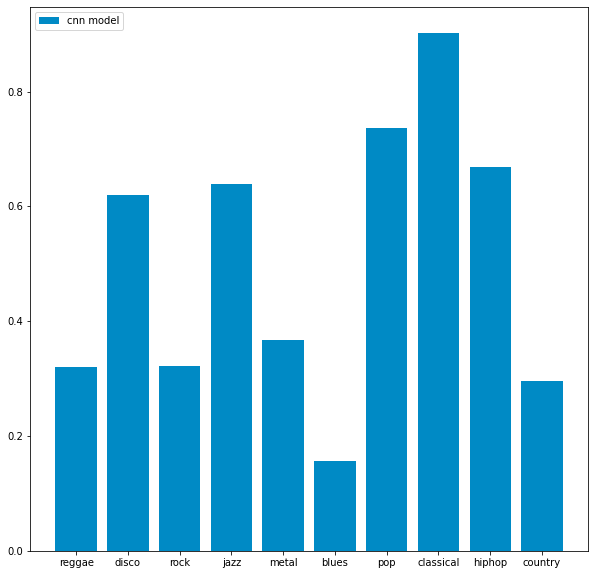

In [53]:
with open(Para.LOG_SAVE_FOLDER + 'cnnFullSongTest.json', 'r') as f:
    cnnFullSongTest = json.load(f)

plt.figure(figsize=(10, 10))
plt.bar(range(len(cnnFullSongTest)), cnnFullSongTest.values(), 
        align='center', 
        color= '#008ac5',
        label='cnn model')
plt.xticks(range(len(cnnFullSongTest)), cnnFullSongTest.keys())
plt.legend(loc="upper left")
plt.show()